In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib


In [117]:
# Load dataset
df= pd.read_csv("/content/House Price Prediction Dataset.csv")
df.head(10)

,Id,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location,Condition,Garage,Price
0,1,1360,5,4,3,1970,Downtown,Excellent,No,149919
1,2,4272,5,4,3,1958,Downtown,Excellent,No,424998
2,3,3592,2,2,3,1938,Downtown,Good,No,266746
3,4,966,4,2,2,1902,Suburban,Fair,Yes,244020
4,5,4926,1,4,2,1975,Downtown,Fair,Yes,636056
5,6,3944,1,2,1,1906,Urban,Poor,No,93262
6,7,3671,1,1,2,1948,Rural,Poor,Yes,448722
7,8,3419,2,4,1,1925,Suburban,Good,Yes,594893
8,9,630,2,2,1,1932,Rural,Poor,Yes,652878
9,10,2185,3,3,1,2000,Downtown,Poor,No,340375


In [119]:
# Display basic info
df.info()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         2000 non-null   int64 
 1   Area       2000 non-null   int64 
 2   Bedrooms   2000 non-null   int64 
 3   Bathrooms  2000 non-null   int64 
 4   Floors     2000 non-null   int64 
 5   YearBuilt  2000 non-null   int64 
 6   Location   2000 non-null   object
 7   Condition  2000 non-null   object
 8   Garage     2000 non-null   object
 9   Price      2000 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 156.4+ KB
                Id         Area     Bedrooms   Bathrooms       Floors  \
count  2000.000000  2000.000000  2000.000000  2000.00000  2000.000000   
mean   1000.500000  2786.209500     3.003500     2.55250     1.993500   
std     577.494589  1295.146799     1.424606     1.10899     0.809188   
min       1.000000   501.000000     1.000000     1.00000     1.000000   
25%     

In [120]:
#Selecting relevant features
numeric_features = ['Area', 'Bedrooms', 'Bathrooms', 'Floors', 'YearBuilt']
categorical_features = ['Location', 'Condition', 'Garage']  # Assuming these exist in dataset
label = 'Price'

# Assign df to data, so all columns are included
data = df[numeric_features + categorical_features + [label]].dropna()

In [121]:
# Selecting relevant features
df = df[['Area', 'Bedrooms', 'Bathrooms', 'Price']]

# Check for missing values
df.isnull().sum()


,0
Area,0
Bedrooms,0
Bathrooms,0
Price,0


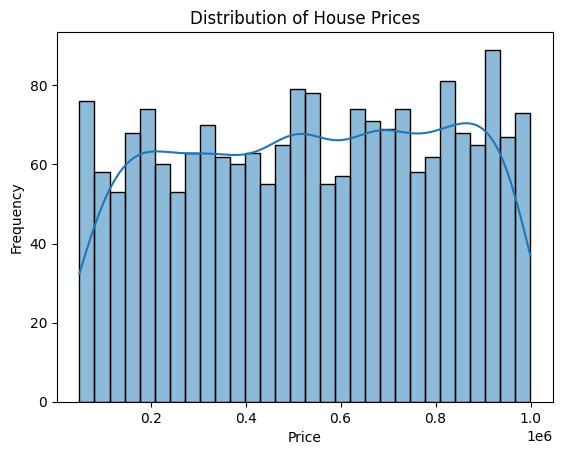

In [122]:
# Plot distribution of house prices
sns.histplot(df['Price'], bins=30, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


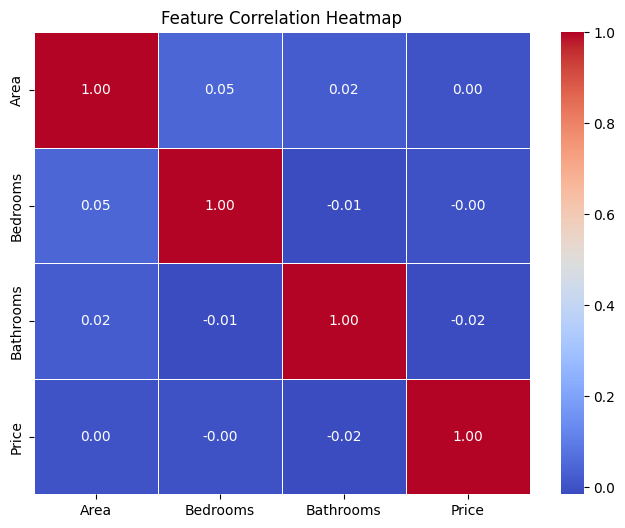

In [126]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [127]:
#Handling outliers (Removing extreme values)
for col in numeric_features:
    q1, q3 = np.percentile(data[col], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

In [128]:
#Selecting relevant features and target variable
X = df[['Area', 'Bedrooms', 'Bathrooms']]
y = df['Price']

In [129]:
# Splitting into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((1600, 3), (400, 3))

In [130]:
#improve the model performance
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:5]  # Showing first 5 rows of scaled training data

array([[ 1.31408123,  0.68575834,  1.31608835],
       [-1.31595997, -0.01488875,  0.41427192],
       [-1.03919445, -0.01488875,  1.31608835],
       [-0.08896618, -0.71553584,  0.41427192],
       [ 0.39383589, -0.71553584,  1.31608835]])

In [131]:
#Preprocessing Pipeline
numeric_features = ['Area', 'Bedrooms', 'Bathrooms']
categorical_features = []  # Empty since no categorical features are in X

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [132]:
#Train Random Forest Model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Area', 'Bedrooms',
                                                   'Bathrooms']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [133]:
#Predictions
y_pred = model.predict(X_test)

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [135]:
# Hyperparameter tuning for Ridge Regression
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = GridSearchCV(Ridge(), ridge_params, cv=5)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.best_estimator_.predict(X_test)

In [140]:
# Evaluating Ridge Regression
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression Best Alpha: {ridge.best_params_['alpha']}")
print(f"MAE: {mae_ridge}")
print(f"MSE: {mse_ridge}")
print(f"R² Score: {r2_ridge}")

Ridge Regression Best Alpha: 100
MAE: 243691.78319906408
MSE: 78406915997.09021
R² Score: -0.007816152103566676


In [142]:
#Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Evaluate the model performance using y_pred, the predictions from the RandomForestRegressor
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R² Score: {r2}")

MAE: 270134.03943214286
MSE: 104252284137.59064
R² Score: -0.3400238296766256


In [143]:
#Save the model for future use
joblib.dump(model, "house_price_model.pkl")


['house_price_model.pkl']

In [144]:
#Save the model and scaler for future use
joblib.dump(model, "house_price_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(poly, "poly_features.pkl")


['poly_features.pkl']

In [157]:
from sklearn.linear_model import LinearRegression
# Initialize and train the Linear Regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)


LinearRegression()

In [158]:
# Make predictions
y_pred_linear = linear_reg.predict(X_test)

In [159]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred_linear)
mse = mean_squared_error(y_test, y_pred_linear)
r2 = r2_score(y_test, y_pred_linear)

print("Linear Regression Results:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R² Score: {r2}")


Linear Regression Results:
MAE: 243756.4797682511
MSE: 78440549944.81049
R² Score: -0.008248471565956539


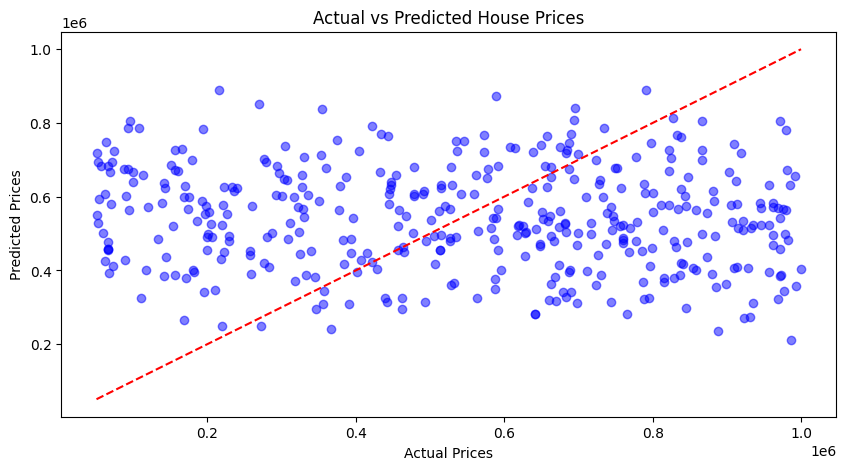

In [160]:
# Step 11: Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()
